In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

In [2]:
def automato_celular(p_contaminacao, p_recuperacao):
    # Inicialização da rede
    rede = np.zeros((N, N), dtype=int)
    rede[np.random.randint(N)][np.random.randint(N)] = 1  # Indivíduo contaminado

    # Lista para armazenar as populações médias
    populacao_suscetiveis_media = []
    populacao_infectados_media = []
    populacao_recuperados_media = []

    # Lista para armazenar as distribuições espaciais
    distribuicoes_espaciais = []

    for _ in range(T):
        # Criação de uma cópia da rede atual para a próxima iteração
        nova_rede = np.copy(rede)

        # Loop sobre cada célula da rede
        for i in range(N):
            for j in range(N):
                if rede[i][j] == 1:  # Indivíduo infectado
                    # Verificação dos vizinhos
                    for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                        ni, nj = (i + di) % N, (j + dj) % N  # Condições de contorno periódicas

                        if rede[ni][nj] == 0:  # Vizinho suscetível
                            if np.random.rand() < p_contaminacao:
                                nova_rede[ni][nj] = 1

                    # Verificação da recuperação
                    if np.random.rand() < p_recuperacao:
                        nova_rede[i][j] = 2  # Indivíduo recuperado

        rede = nova_rede

        # Cálculo das populações médias
        populacao_suscetiveis_media.append(np.count_nonzero(rede == 0) / (N*N))
        populacao_infectados_media.append(np.count_nonzero(rede == 1) / (N*N))
        populacao_recuperados_media.append(np.count_nonzero(rede == 2) / (N*N))

        # Armazenamento das distribuições espaciais
        distribuicoes_espaciais.append(np.copy(rede))

    return populacao_suscetiveis_media, populacao_infectados_media, populacao_recuperados_media, distribuicoes_espaciais

In [3]:
# Definição das constantes
N = 100  # Tamanho da rede (100x100)
T = 100  # Número de estágios de tempo
num_simulacoes = 5  # Número de simulações a serem realizadas
p_contaminacao = [0.4, 0.6, 0.8]  # Probabilidades de contaminação
p_recuperacao = [0.1, 0.3, 0.5]  # Probabilidades de recuperação

# Executando as simulações para diferentes conjuntos de probabilidades
resultados_simulacoes = []

for p_c in p_contaminacao:
    for p_r in p_recuperacao:
        simulacoes = []

        for _ in range(num_simulacoes):
            resultado = automato_celular(p_c, p_r)
            simulacoes.append(resultado)

        resultados_simulacoes.append(simulacoes)

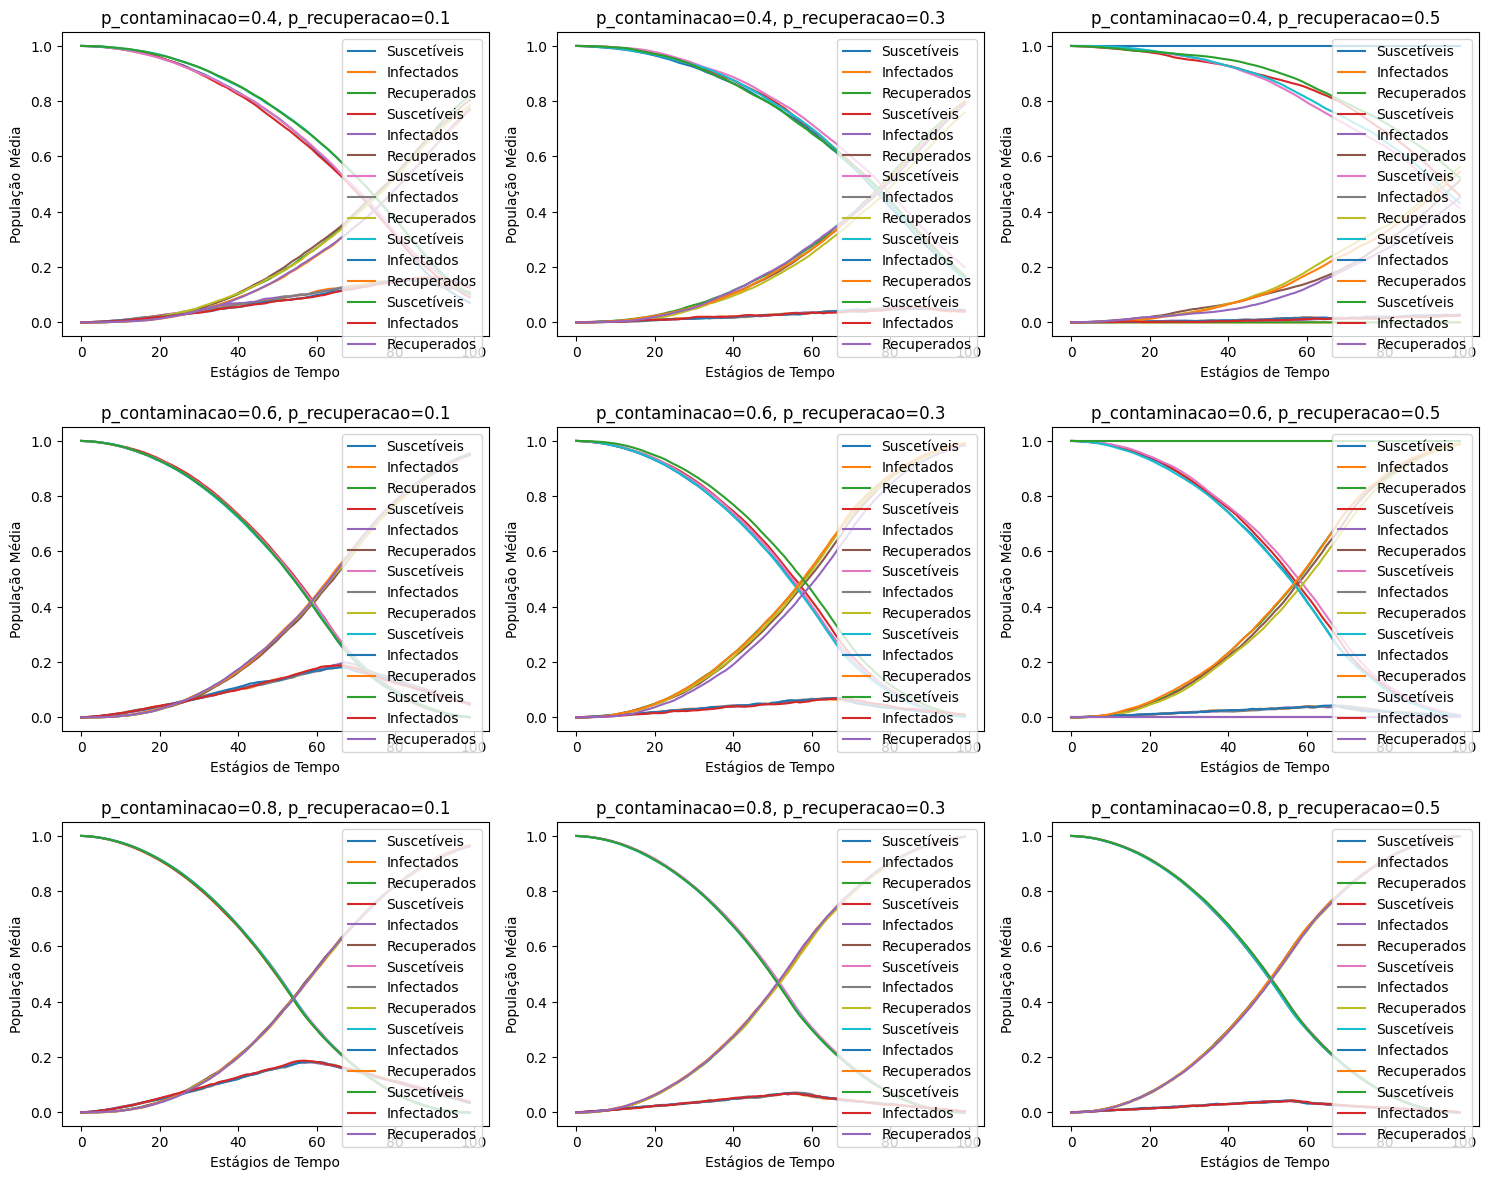

In [4]:
# Visualização dos resultados
fig, axs = plt.subplots(len(p_contaminacao), len(p_recuperacao), figsize=(15, 12))

for i, p_c in enumerate(p_contaminacao):
    for j, p_r in enumerate(p_recuperacao):
        axs[i][j].set_title(f'p_contaminacao={p_c}, p_recuperacao={p_r}')
        axs[i][j].set_xlabel('Estágios de Tempo')
        axs[i][j].set_ylabel('População Média')

        for simulacao in resultados_simulacoes[i * len(p_recuperacao) + j]:
            axs[i][j].plot(simulacao[0], label='Suscetíveis')
            axs[i][j].plot(simulacao[1], label='Infectados')
            axs[i][j].plot(simulacao[2], label='Recuperados')

        axs[i][j].legend()

plt.tight_layout()
plt.show()

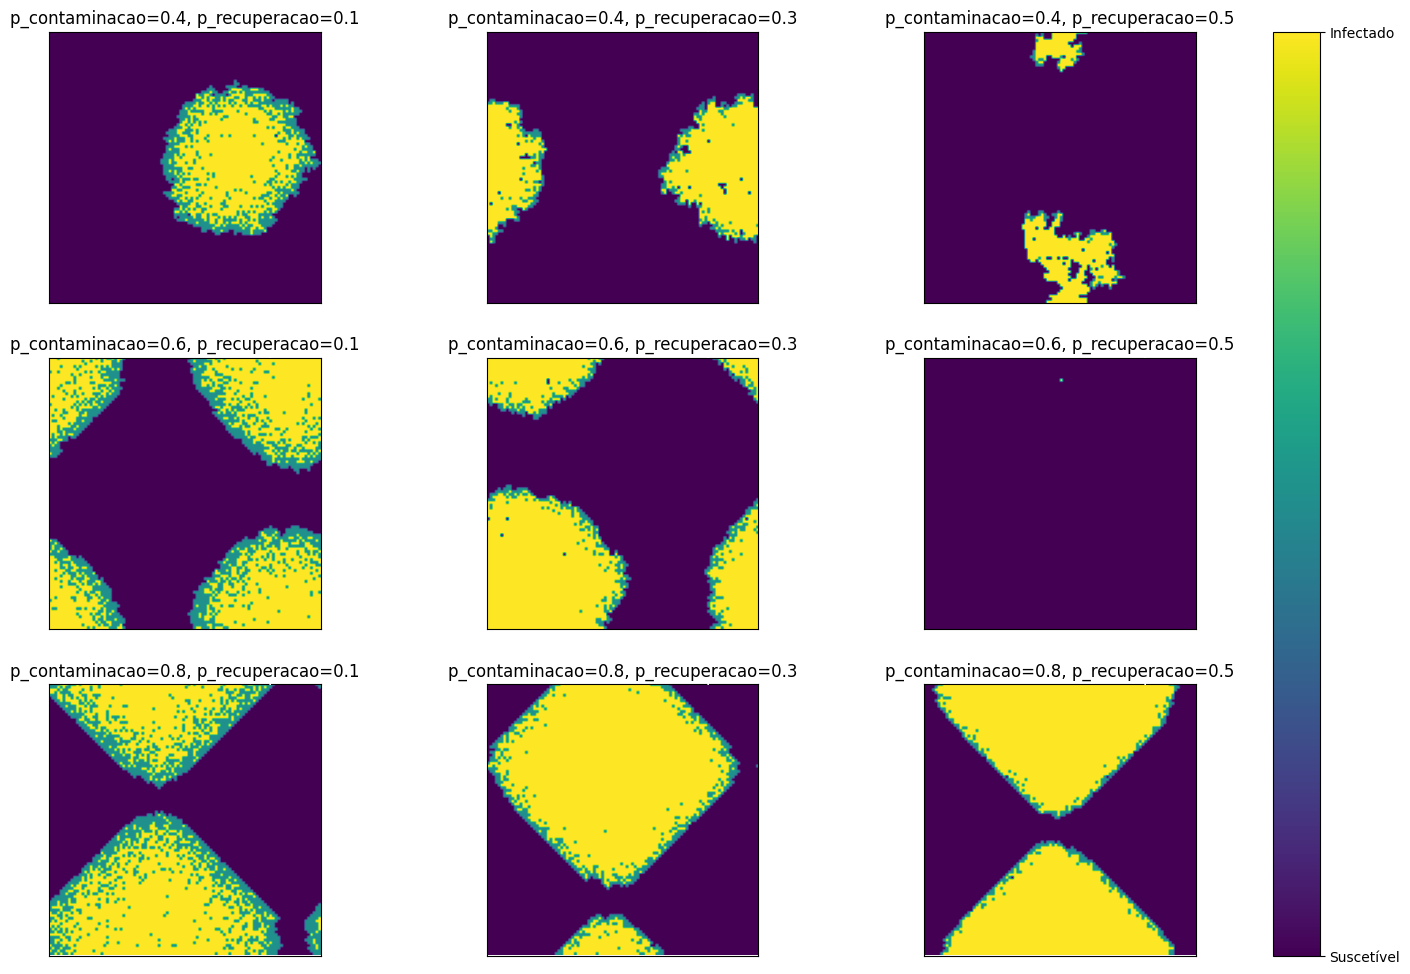

In [9]:
# Período de tempo a ser visualizado
tempo_visualizacao = T // 2  # Meio do período total

# Visualização da evolução da doença para cada configuração
fig, axs = plt.subplots(len(p_contaminacao), len(p_recuperacao), figsize=(20, 12))

for i, p_c in enumerate(p_contaminacao):
    for j, p_r in enumerate(p_recuperacao):
        axs[i][j].set_title(f'p_contaminacao={p_c}, p_recuperacao={p_r}')
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])

        # Encontrando o índice correspondente na lista de resultados
        index = p_contaminacao.index(p_c) * len(p_recuperacao) + p_recuperacao.index(p_r)

        # Obtendo os resultados para a configuração escolhida
        resultados = resultados_simulacoes[index]

        # Mostrando a evolução da doença no período de tempo visualizado
        axs[i][j].imshow(resultados[-1][3][tempo_visualizacao],
                         cmap='viridis', vmin=0, vmax=2)
        axs[i][j].text(1, 1, f'Tempo: {tempo_visualizacao}', color='white', fontsize=12,
                       ha='right', va='bottom', transform=axs[i][j].transAxes)

# Adicionando a legenda
# parâmetro mappable para colorbar:
mappable = plt.cm.ScalarMappable(cmap='viridis')
cbar = fig.colorbar(mappable, ax=axs[:, :], ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['Suscetível', 'Infectado', 'Recuperado'])

plt.show()

## Aplicação em Redes de Mundo pequeno

In [6]:
# Dessa vez usaremos small world networks ao invés de redes regulares
# Função para criar uma rede small world
def rede_small_world(N, k, p):
    # Criação de uma rede regular
    rede = np.zeros((N, N), dtype=int)

    for i in range(N):
        for j in range(1, k // 2 + 1):
            rede[i][(i + j) % N] = 1
            rede[i][(i - j) % N] = 1

    # Reorganização dos links
    for i in range(N):
        for j in range(1, k // 2 + 1):
            if np.random.rand() < p:
                rede[i][(i + j) % N] = 0
                rede[i][(i - j) % N] = 0

                while True:
                    novo_vizinho = np.random.randint(0, N)

                    if novo_vizinho != i and rede[i][novo_vizinho] == 0:
                        rede[i][novo_vizinho] = 1
                        break

    return rede

# Função para executar o autômato celular
def automato_celular_small_world(p_contaminacao, p_recuperacao):
    # Criação da rede
    rede = rede_small_world(N, 4, 0.2)

    # Criação das listas para armazenar as populações médias
    populacao_suscetiveis_media = []
    populacao_infectados_media = []
    populacao_recuperados_media = []

    # Criação da lista para armazenar as distribuições espaciais
    distribuicoes_espaciais = []

    # Execução do autômato celular
    for t in range(T):
        nova_rede = np.copy(rede)

        for i in range(N):
            for j in range(N):
                # Verificação da contaminação
                if rede[i][j] == 1:
                    for ni in range(i - 1, i + 2):
                        for nj in range(j - 1, j + 2):
                            if ni == i and nj == j:
                                continue

                            if rede[ni % N][nj % N] == 0:
                                if np.random.rand() < p_contaminacao:
                                    nova_rede[ni % N][nj % N] = 1

                    # Verificação da recuperação
                    if np.random.rand() < p_recuperacao:
                        nova_rede[i][j] = 2  # Indivíduo recuperado

        rede = nova_rede

        # Cálculo das populações médias
        populacao_suscetiveis_media.append(np.count_nonzero(rede == 0) / (N*N))
        populacao_infectados_media.append(np.count_nonzero(rede == 1) / (N*N))
        populacao_recuperados_media.append(np.count_nonzero(rede == 2) / (N*N))

        # Armazenamento das distribuições espaciais
        distribuicoes_espaciais.append(np.copy(rede))

    return populacao_suscetiveis_media, populacao_infectados_media, populacao_recuperados_media, distribuicoes_espaciais

In [9]:
for p_c in p_contaminacao:
    for p_r in p_recuperacao:
        simulacoes = []

        for _ in range(num_simulacoes):
            resultado = automato_celular_small_world(p_c, p_r)
            simulacoes.append(resultado)

        resultados_simulacoes.append(simulacoes)

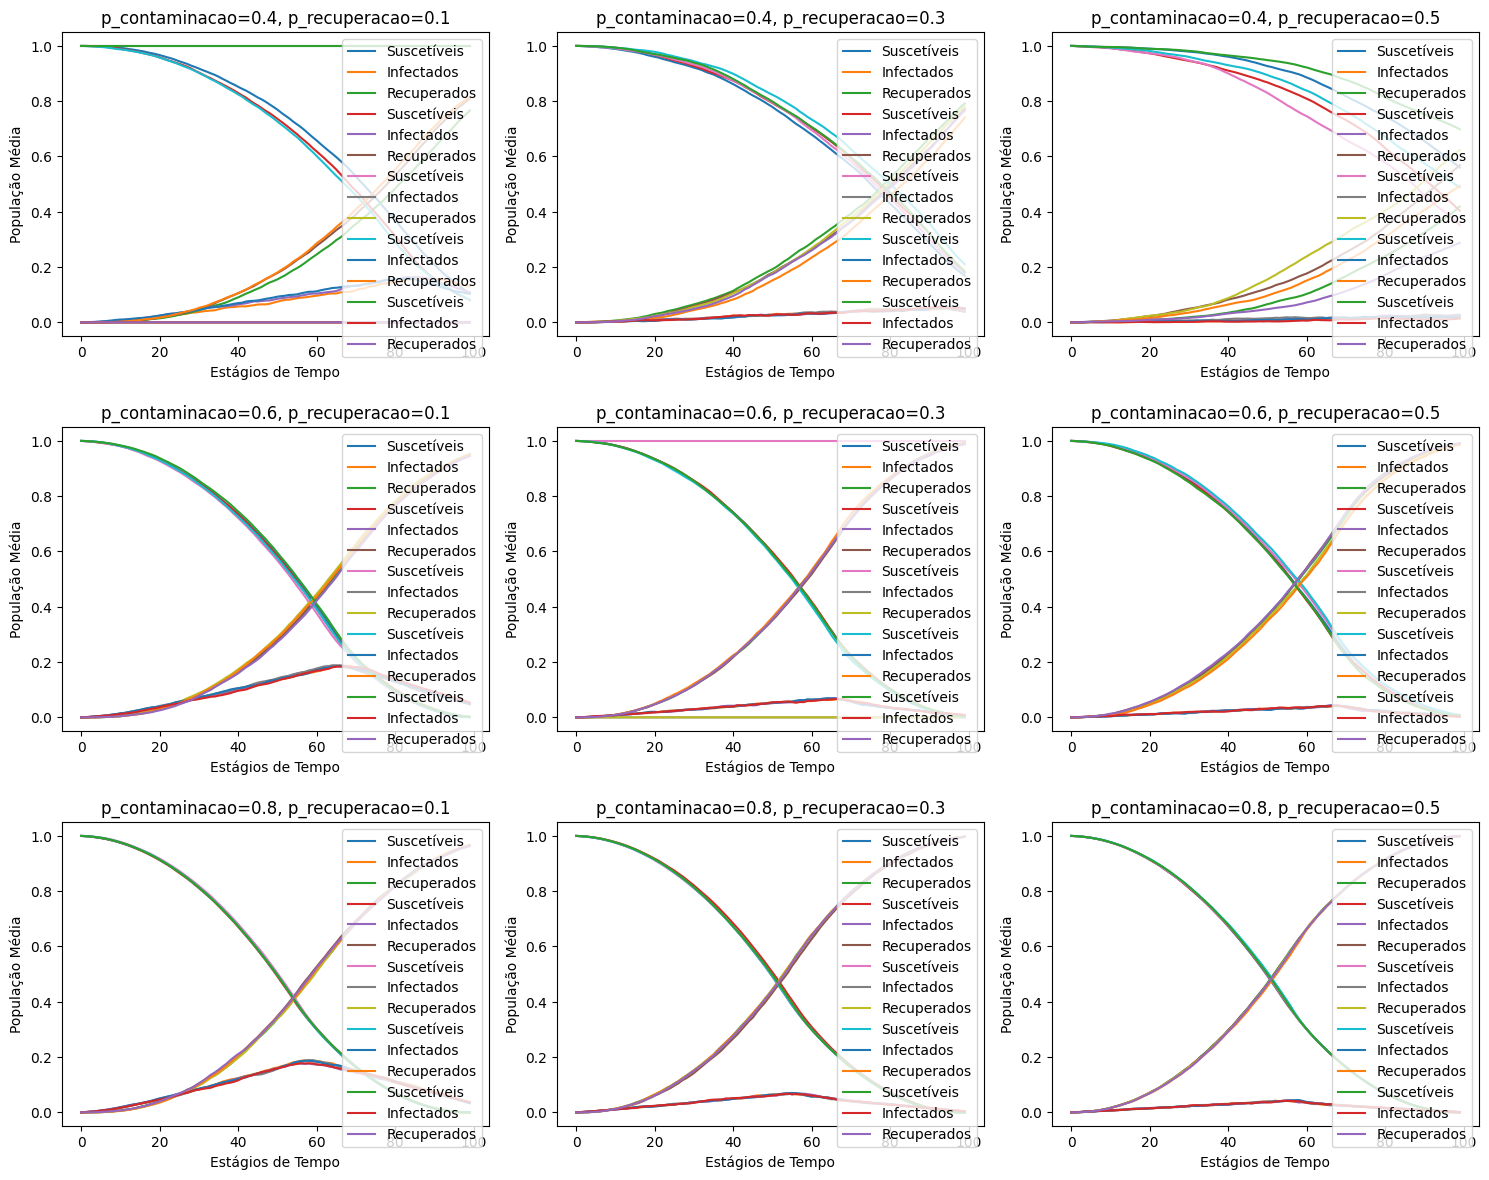

In [10]:
fig, axs = plt.subplots(len(p_contaminacao), len(p_recuperacao), figsize=(15, 12))

for i, p_c in enumerate(p_contaminacao):
    for j, p_r in enumerate(p_recuperacao):
        axs[i][j].set_title(f'p_contaminacao={p_c}, p_recuperacao={p_r}')
        axs[i][j].set_xlabel('Estágios de Tempo')
        axs[i][j].set_ylabel('População Média')

        for simulacao in resultados_simulacoes[i * len(p_recuperacao) + j]:
            axs[i][j].plot(simulacao[0], label='Suscetíveis')
            axs[i][j].plot(simulacao[1], label='Infectados')
            axs[i][j].plot(simulacao[2], label='Recuperados')

        axs[i][j].legend()

plt.tight_layout()
plt.show()

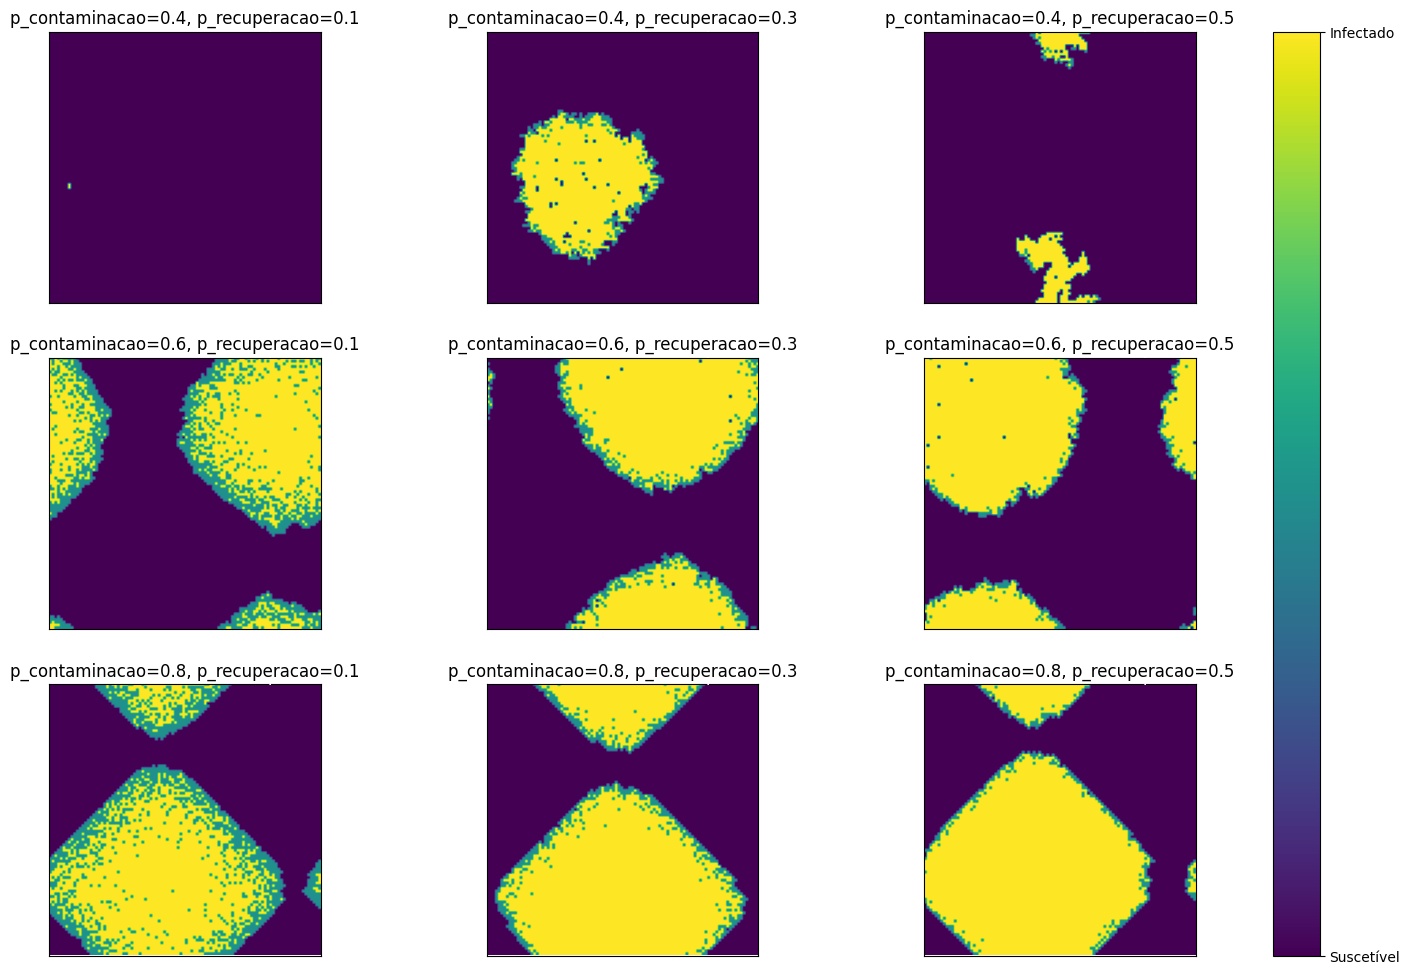

In [11]:
tempo_visualizacao = T // 2  # Meio do período total

# Visualização da evolução da doença para cada configuração
fig, axs = plt.subplots(len(p_contaminacao), len(p_recuperacao), figsize=(20, 12))

for i, p_c in enumerate(p_contaminacao):
    for j, p_r in enumerate(p_recuperacao):
        axs[i][j].set_title(f'p_contaminacao={p_c}, p_recuperacao={p_r}')
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])

        # Encontrando o índice correspondente na lista de resultados
        index = p_contaminacao.index(p_c) * len(p_recuperacao) + p_recuperacao.index(p_r)

        # Obtendo os resultados para a configuração escolhida
        resultados = resultados_simulacoes[index]

        # Mostrando a evolução da doença no período de tempo visualizado
        axs[i][j].imshow(resultados[-1][3][tempo_visualizacao],
                         cmap='viridis', vmin=0, vmax=2)
        axs[i][j].text(1, 1, f'Tempo: {tempo_visualizacao}', color='white', fontsize=12,
                       ha='right', va='bottom', transform=axs[i][j].transAxes)

# Adicionando a legenda
# parâmetro mappable para colorbar:
mappable = plt.cm.ScalarMappable(cmap='viridis')
cbar = fig.colorbar(mappable, ax=axs[:, :], ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['Suscetível', 'Infectado', 'Recuperado'])

plt.show()

No caso de redes de mundo pequeno, as redes são geradas com um número de nós $N$ e um número de vizinhos $k$ para cada nó. A rede é gerada de forma que cada nó é conectado aos $k$ vizinhos mais próximos, de forma que a distância entre dois nós quaisquer é menor ou igual a $k/2$.

Uma vez que a rede quadrada é mais bem definida e cada célula tem um número invariável de vizinhos, a evolução da doença se porta de modo mais comportado, menos coerente com observado na vida real, que inclui situações em que um só infectado pode causar o espalhamento da doença de modo muito grande, caso tenha contato com muitas pessoas. A propagação da doença pode ser mais heterogênea na rede de mundo pequeno, devido à presença de células altamente conectadas que podem funcionar como "pontes" para a contaminação mais rápida e espalhada.